In [1]:
pip install tensorflow keras matplotlib seaborn scikit-learn pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import pandas as pd  
import numpy as np 
import cv2 as cv  
import os  
import tensorflow as tf 
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import keras as k
from keras.layers import Conv2D,Flatten,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras import optimizers as k
from tensorflow.keras import optimizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model  
from keras.models import Sequential  
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten  
from keras.optimizers import Adam  
from keras.layers import BatchNormalization  
from keras.regularizers import l2  
from keras.callbacks import ReduceLROnPlateau, EarlyStopping  
import warnings  
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")  
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Dataset paths
original_dataset_dir = 'ck+'
train_dir = 'ck+_train'
test_dir = 'ck+_test'

In [4]:
# Create directories for training and testing datasets if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [5]:
# Define the split ratio
train_ratio = 0.8

In [6]:
# Loop through each emotion category in the original dataset
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        # Get a list of all the image filenames in the emotion category
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]
        
        # Randomly shuffle the list of image filenames
        np.random.shuffle(images)
        
        # Split the list of image filenames into training and testing sets
        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]
        
        # Create directories for the emotion category in the train and test datasets
        train_emotion_dir = os.path.join(train_dir, emotion)
        test_emotion_dir = os.path.join(test_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)
        
        # Copy the images into the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Dataset splitting complete")

Dataset splitting complete


In [7]:
# Create a data generator with augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=15,  
    width_shift_range=0.15,  
    height_shift_range=0.15,  
    shear_range=0.15, 
    zoom_range=0.15,  
    horizontal_flip=True,  
)

# Load images from the directory and apply the defined transformations
fer_training_data = train_data_generator.flow_from_directory(
    'ck+_train',  
    target_size=(48, 48),  
    batch_size=64,  
    color_mode='grayscale',  
    class_mode='categorical'  
)

fer_training_data

Found 783 images belonging to 7 classes.


In [8]:
# Initialize an ImageDataGenerator for test data with rescaling

test_data_generator = ImageDataGenerator(rescale=1./255)

# Creates a data generator for the test dataset

fer_test_data = test_data_generator.flow_from_directory(
    'ck+_test',  
    target_size = (48, 48),  # Resizes images to 48x48 pixels
    batch_size = 64,  
    color_mode = 'grayscale',  
    class_mode = 'categorical'  
)

# fer_test_data is now a generator that yields batches of test images and their labels
fer_test_data

Found 198 images belonging to 7 classes.


In [9]:
## Initializing a list of optimizers with specific configurations
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [10]:
# Defining CNN model
model = Sequential()

model.add(
        Conv2D(
            filters=512,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
        Conv2D(
            filters=256,
            kernel_size=(5,5),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
model.add(BatchNormalization(name='batchnorm_2'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.25, name='dropout_1'))

model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
model.add(BatchNormalization(name='batchnorm_4'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.25, name='dropout_2'))

model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
model.add(BatchNormalization(name='batchnorm_6'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.25, name='dropout_3'))

model.add(Flatten(name='flatten'))
        
model.add(
        Dense(
            256,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_7'))
    
model.add(Dropout(0.25, name='dropout_4'))
    
model.add(
        Dense(
            7,
            activation='softmax',
            name='out_layer'
        )
    )
    
model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 256)    │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,937,159 (37.91 MB)

 Trainable params: 9,933,063 (37.89 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [11]:
# Reduce learning rate when a metric has stopped improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
batch_size = 64
history = model.fit(
    fer_training_data,
    epochs=100, 
    validation_data=fer_test_data,
    batch_size = 64,
    callbacks=callbacks,
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step - accuracy: 0.2628 - loss: 2.3221 - val_accuracy: 0.2071 - val_loss: 108.1322 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.5077 - loss: 1.3997 - val_accuracy: 0.1364 - val_loss: 139.1390 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.5740 - loss: 1.1731 - val_accuracy: 0.1364 - val_loss: 52.8525 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.5979 - loss: 1.0753 - val_accuracy: 0.1566 - val_loss: 18.1352 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.6772 - loss: 0.8955 - val_accuracy: 0.2525 - val_loss: 12.1266 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.6713 - loss: 0.8803 - val_accuracy: 0.3485 - val_loss: 10.4504 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.6928 - loss: 0.8455 

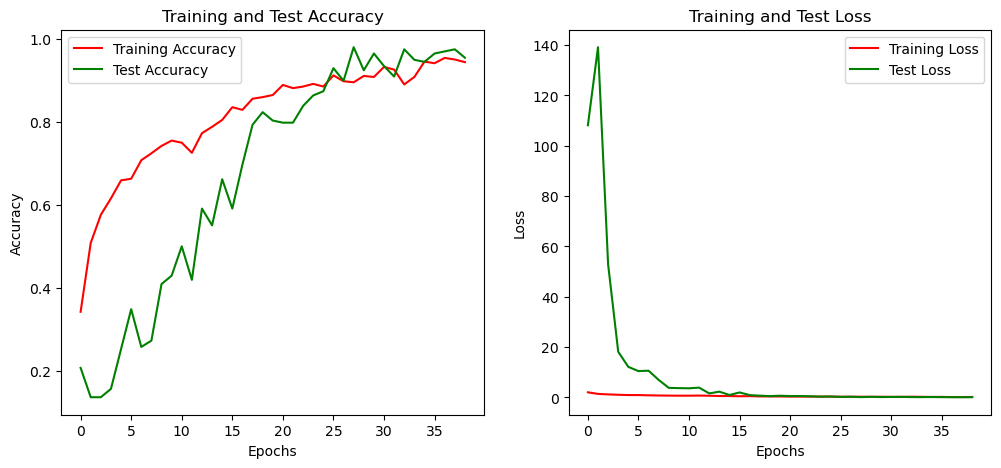

In [34]:
import matplotlib.pyplot as plt
# Accuracy and loss plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='green')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Test Loss', color='green')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training and Test Loss")

plt.show()

In [36]:
Y_pred = model.predict(fer_test_data)
y_pred = np.argmax(Y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


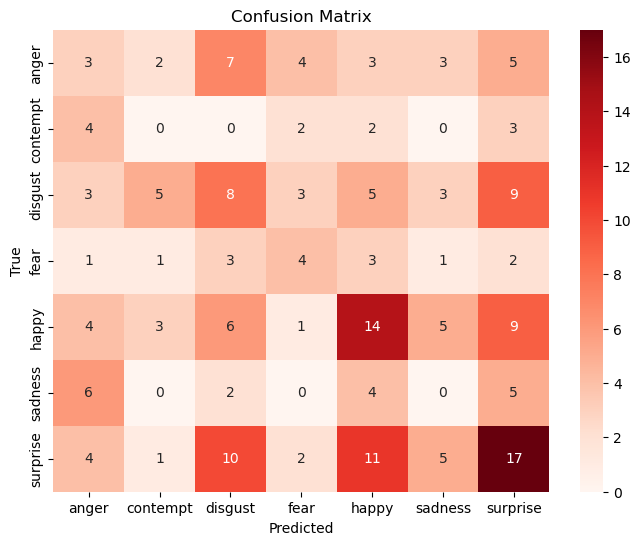

Classification Report:
              precision    recall  f1-score   support

       anger       0.12      0.11      0.12        27
    contempt       0.00      0.00      0.00        11
     disgust       0.22      0.22      0.22        36
        fear       0.25      0.27      0.26        15
       happy       0.33      0.33      0.33        42
     sadness       0.00      0.00      0.00        17
    surprise       0.34      0.34      0.34        50

    accuracy                           0.23       198
   macro avg       0.18      0.18      0.18       198
weighted avg       0.23      0.23      0.23       198



In [38]:
# Predictions
Y_pred = model.predict(fer_test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(fer_test_data.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=fer_test_data.class_indices.keys(),
            yticklabels=fer_test_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(fer_test_data.classes, y_pred, target_names=list(fer_test_data.class_indices.keys())))

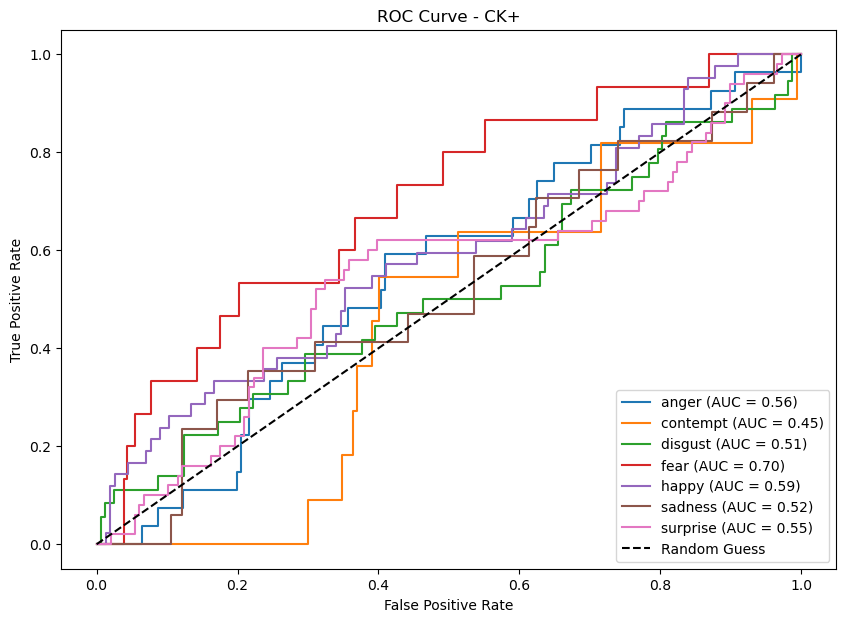

In [40]:
# One-hot encoding
y_true_bin = label_binarize(fer_test_data.classes, classes=range(fer_training_data.num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(fer_training_data.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(10, 7))
for i in range(fer_training_data.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{list(fer_test_data.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CK+')
plt.legend(loc='lower right')
plt.show()